In [1]:
import random
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar

import albumentations as A

from lunglens.data import *
from lunglens.loaders import *

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [2]:
root_dir = Path('../data/prepared/covid19-ct-scans')
df = pd.read_csv(root_dir / 'metadata.csv')
df.label = df.label.astype('category').cat.codes

In [9]:
train_tfms = img_tfm(A.Compose([
    A.Resize(512, 512),
    A.RandomResizedCrop(384, 384, scale=(.7, 1)),
    ToColorTensor()
]))

val_tfms = img_tfm(A.Compose([
    A.Resize(384, 384),
    ToColorTensor()
]))

In [10]:
df_train, df_val = train_test_split(df, test_size=0.25, random_state=42, stratify=df.label)

In [11]:
train_ds = SliceClassificationDataset(df_train, root_dir, train_tfms)
val_ds = SliceClassificationDataset(df_val, root_dir, val_tfms)

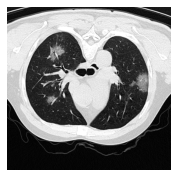

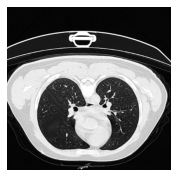

In [17]:
train_img, _ = random.choice(train_ds)
val_img, _ = random.choice(val_ds)

print_slice(train_img[0], figsize=(3,3))
print_slice(val_img[0], figsize=(3,3))

In [18]:
classes = 2
batch_size = 32
device = 'cpu'

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, classes)

In [19]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [21]:
metrics = {
    'loss': Loss(criterion),
    'accuracy': Accuracy(),
}


trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [22]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    metrics = val_evaluator.run(val_loader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} "
          .format(engine.state.epoch, 
                      metrics['loss'], 
                      metrics['accuracy']))


In [23]:
@trainer.on(Events.EPOCH_STARTED)
def turn_on_layers(engine):
    epoch = engine.state.epoch
    if epoch == 1:
        for name, child in model.named_children():
            if name == 'fc':
                pbar.log_message(name + ' is unfrozen')
                for param in child.parameters():
                    param.requires_grad = True
            else:
                pbar.log_message(name + ' is frozen')
                for param in child.parameters():
                    param.requires_grad = False
    if epoch == 3:
        pbar.log_message("Turn on all the layers")
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = True

In [25]:
pbar = ProgressBar(bar_format='')
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

In [ ]:
trainer.run(train_loader, max_epochs=5)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


Validation Results - Epoch: 1  Average Loss: 1.0384 | Accuracy: 0.2341 
